# Anomaly Detection Pipeline – Converted from main.py

In [29]:
import os
import pandas as pd
from config import DEVICES_DATA_PATH, SAVED_MODELS_PATH, global_start_time, process, start_memory
from device_utils import get_device_files, get_model_name, get_numerical_features
from state_anomaly import detect_state_anomalies
from rf_classifier import apply_random_forest, train_rf_for_device
from plotting import plot_lstm_vs_rf, plot_reconstruction_error

In [26]:
def process_device(device_type, csv_file):
    """
    Process a device's data and apply anomaly detection and classification.
    """
    print(f"\n{'=' * 50}")
    print(f"Processing device: {device_type}")
    print(f"{'=' * 50}\n")

    device_start_time = pd.Timestamp.now()
    df_all = pd.DataFrame()

    try:
        df = pd.read_csv(os.path.join(DEVICES_DATA_PATH, csv_file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        available_features = get_numerical_features(df)

        if not available_features:
            print(f"⚠️ {device_type} - No numeric features detected.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")

        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ Missing model for {device_type} state: {state}")
                continue

            df_state = df[df['state'] == state].copy()
            df_processed = detect_state_anomalies(df_state, model_path, available_features)

            if 'reconstruction_error' in df_processed.columns:
                df_all = pd.concat([df_all, df_processed])
                plot_reconstruction_error(df_processed, device_type, state)

        if df_all.empty:
            return None

        df_all.sort_values('timestamp', inplace=True)
        df_all.reset_index(drop=True, inplace=True)

        df_all = apply_random_forest(df_all, device_type)
        plot_lstm_vs_rf(df_all, device_type)

        print(f"✅ Finished {device_type} in {(pd.Timestamp.now() - device_start_time).total_seconds():.2f} sec")
        return df_all

    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        return df_all


Processing device: bale_counter

bale_counter - Auto-detected features: ['average_weight', 'bales', 'total_weight']
Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off_bale_counter.h5: 0.000000 (99.5th percentile)


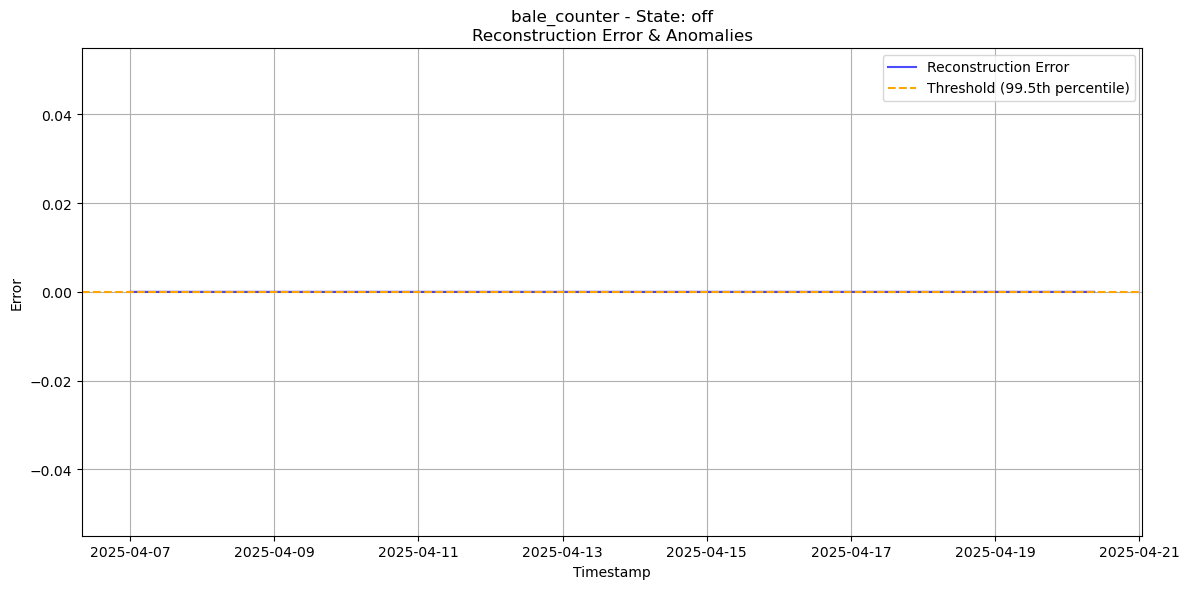

Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_idle_bale_counter.h5: 0.020992 (99.5th percentile)


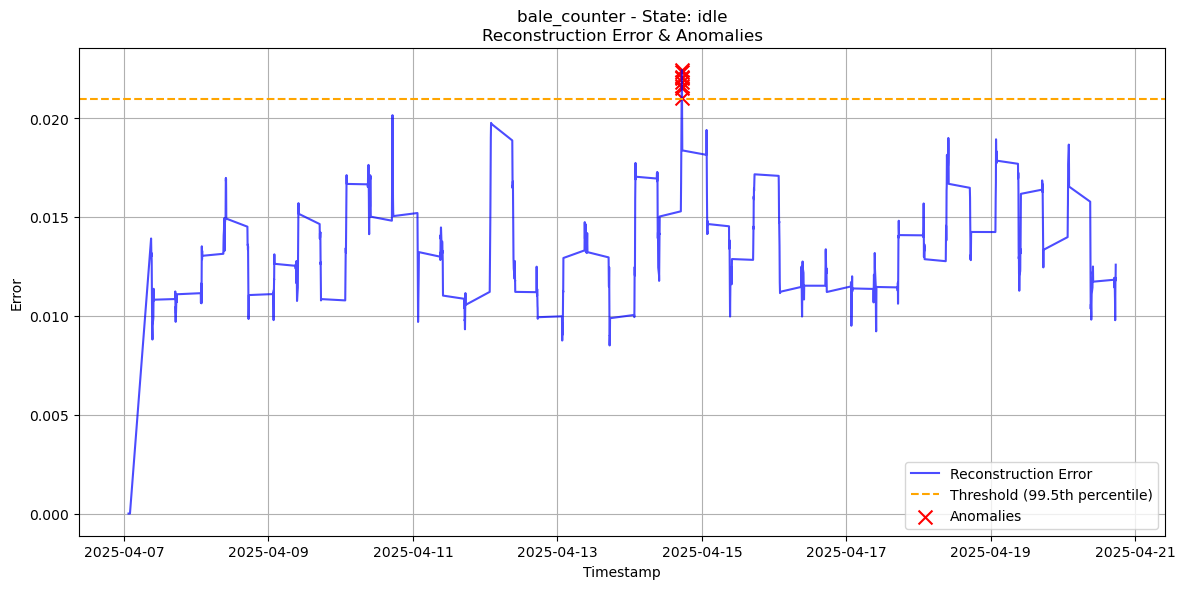

Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_run_bale_counter.h5: 0.013727 (99.5th percentile)


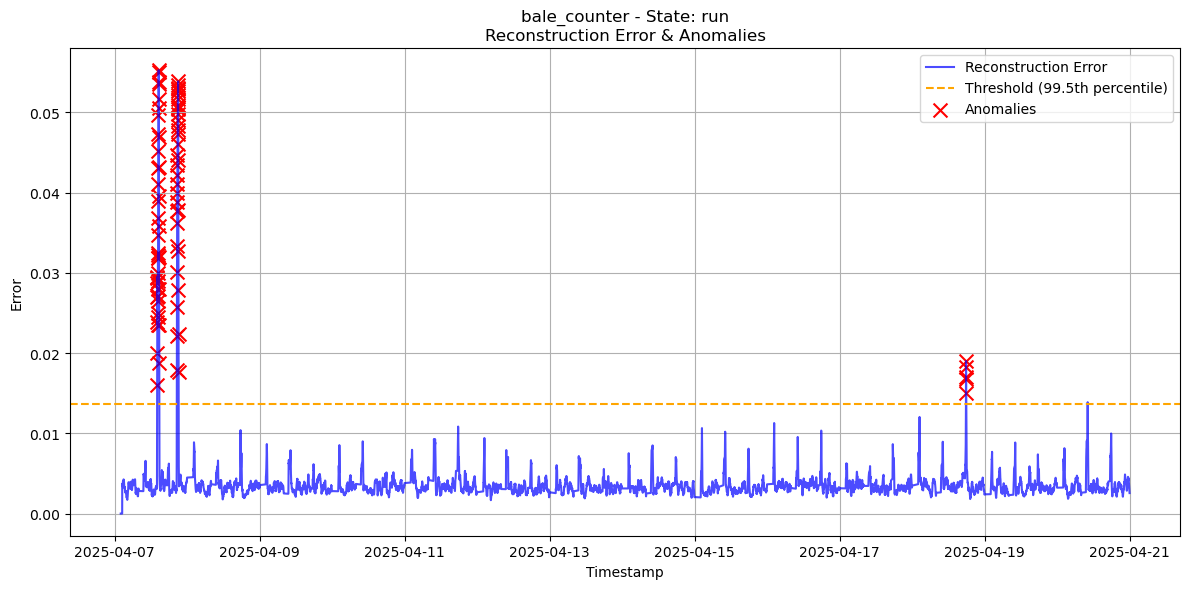

❌ Error processing bale_counter: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- rf_prediction


Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.050289 (99.5th percentile)


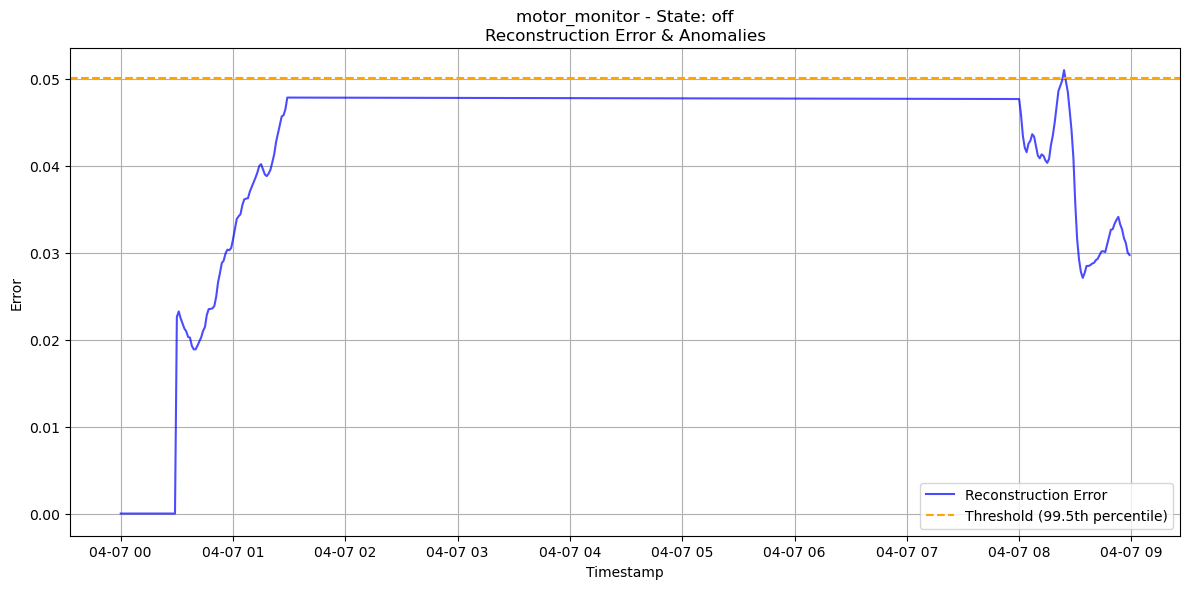

Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_idle.h5: 0.065556 (99.5th percentile)


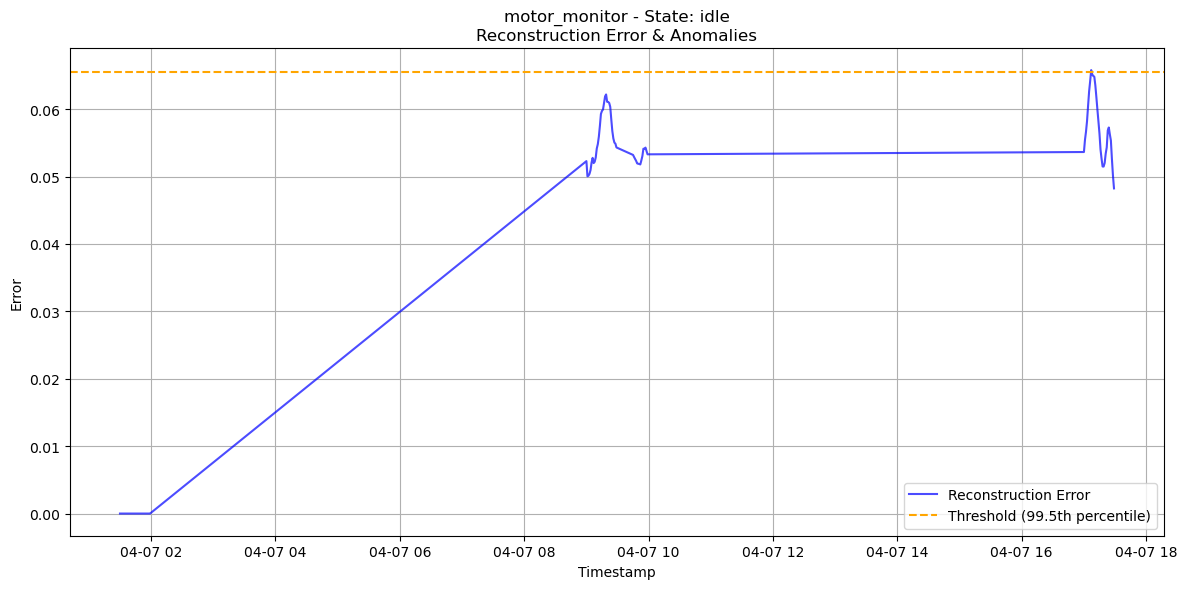

Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_run.h5: 59054.572309 (99.5th percentile)


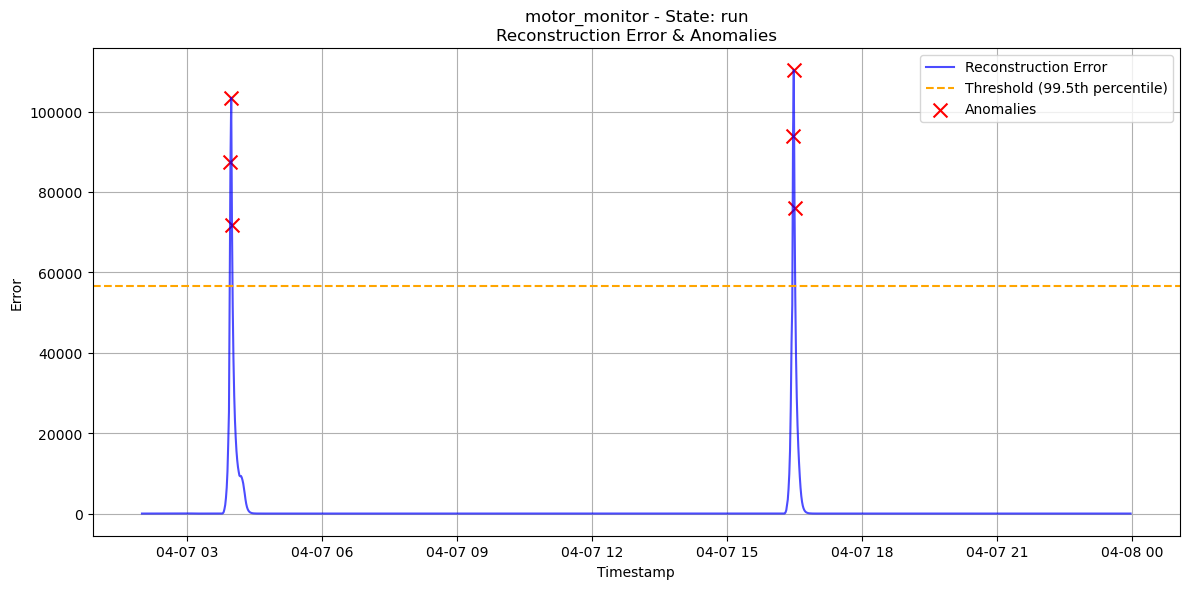

❌ Error processing motor_monitor: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- rf_prediction


Processing device: output_sensor

output_sensor - Auto-detected features: ['output']
Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_long_fiber.h5: 0.026203 (99.5th percentile)


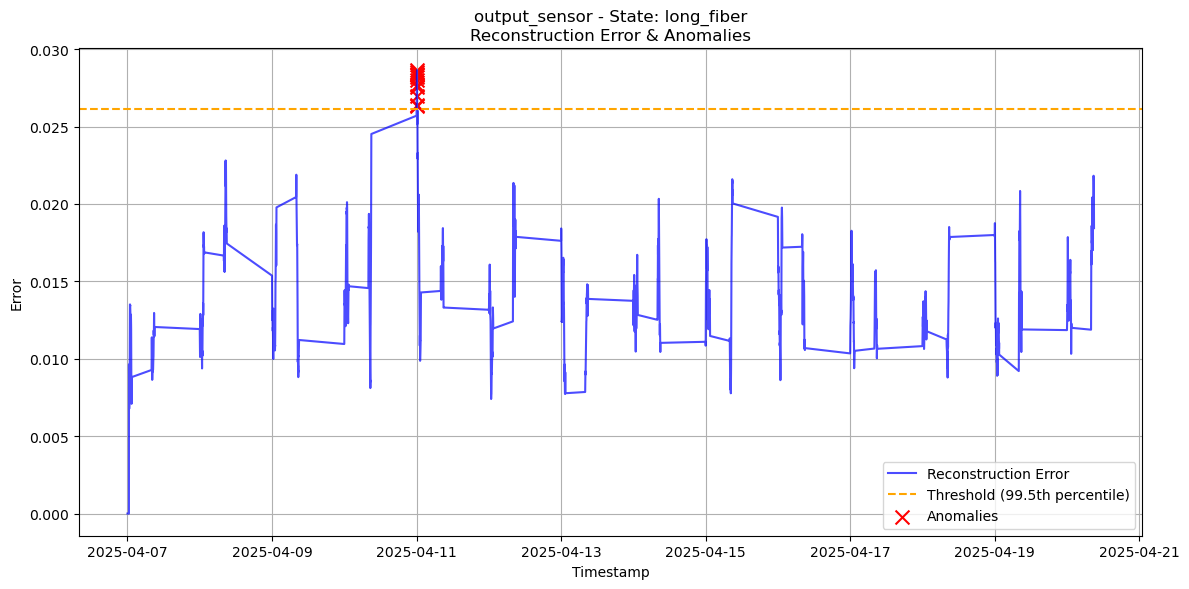

Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_short_fiber.h5: 0.039669 (99.5th percentile)


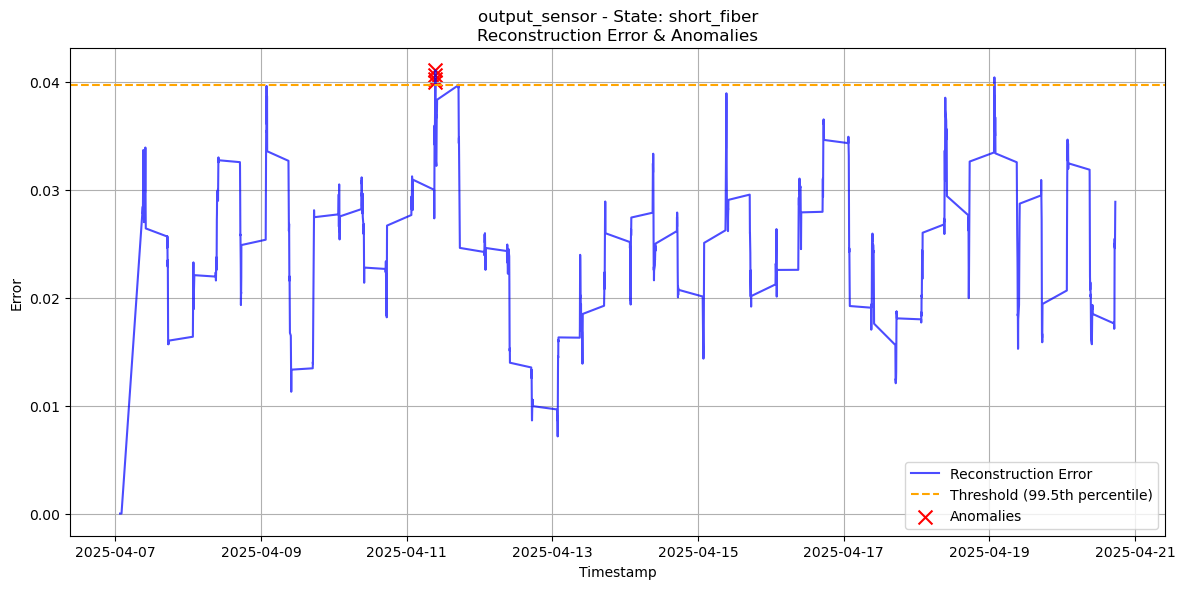

Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_hurd.h5: 0.000486 (99.5th percentile)


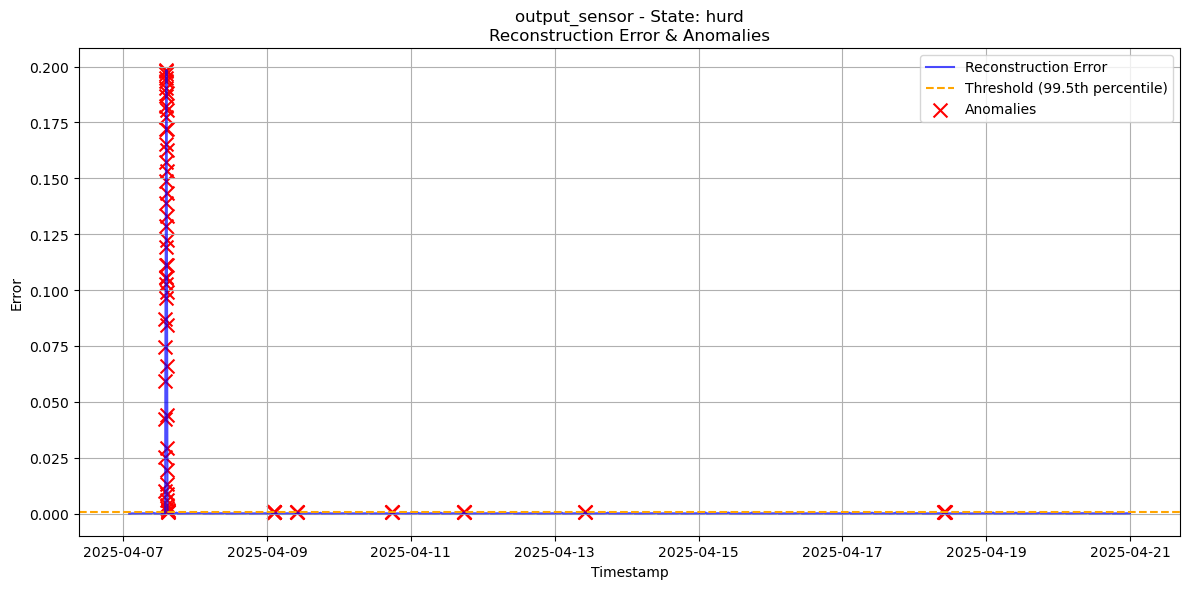

❌ Error processing output_sensor: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- rf_prediction


Processing device: temperature_sensor

temperature_sensor - Auto-detected features: ['temperatureSensor1']
Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off_temperature_sensor.h5: 0.000000 (99.5th percentile)


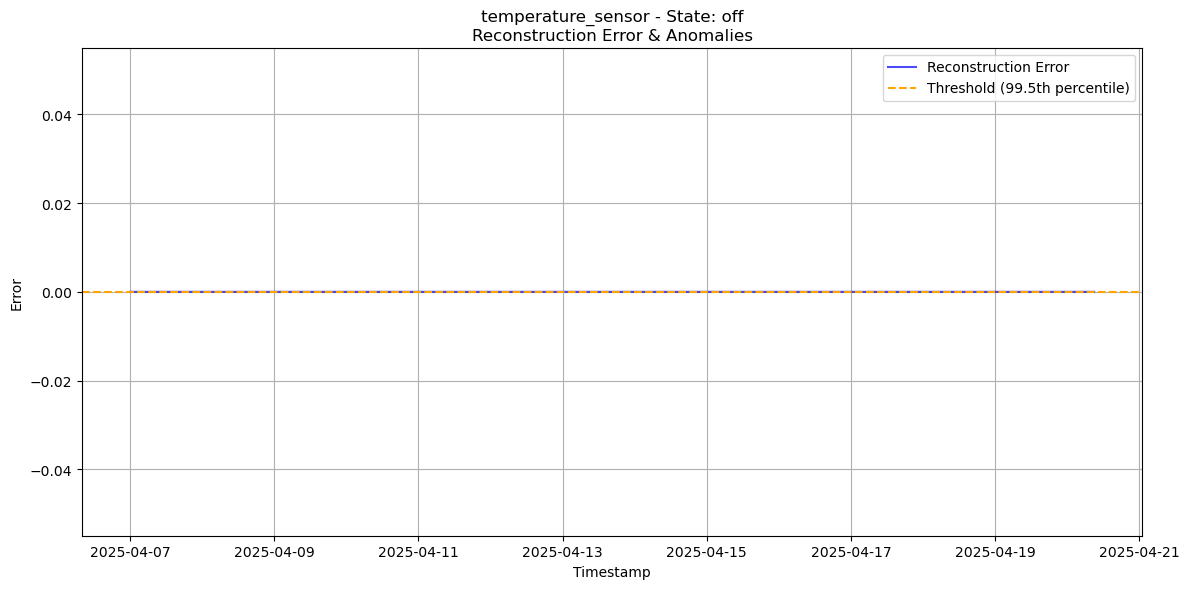

Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_idle_temperature_sensor.h5: 0.000000 (99.5th percentile)


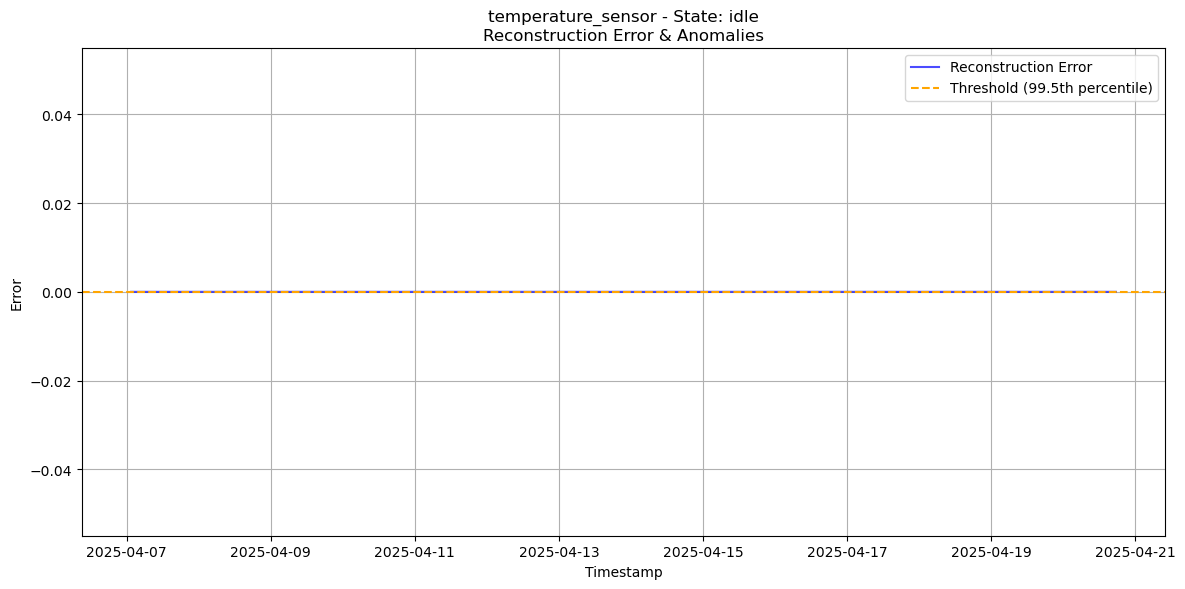

Threshold for c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_run_temperature_sensor.h5: 0.002909 (99.5th percentile)


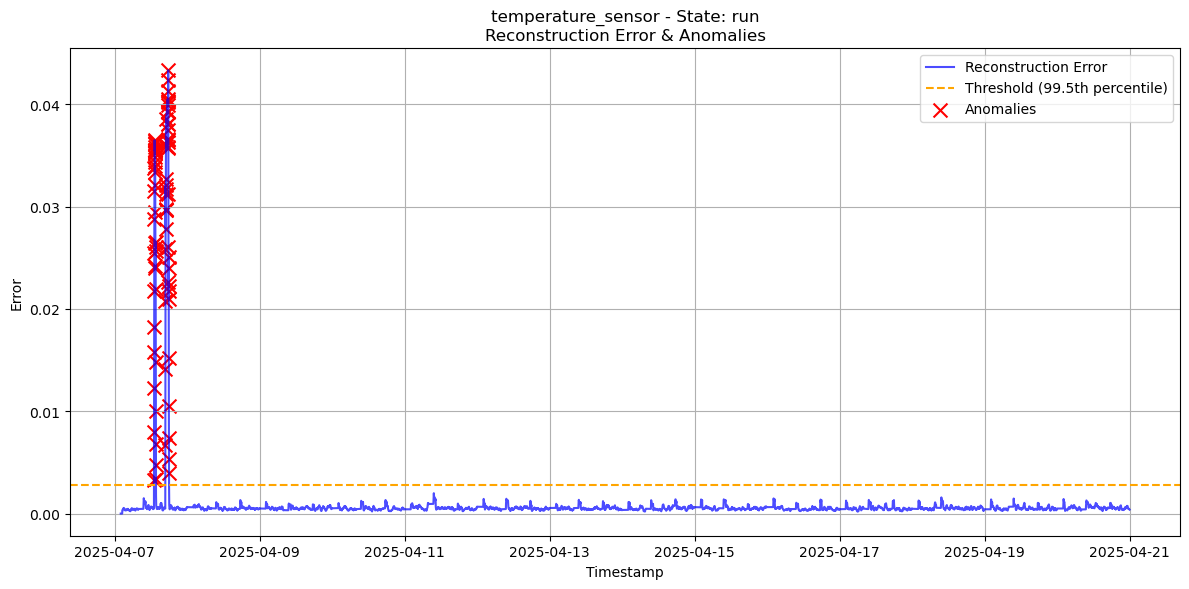

❌ Error processing temperature_sensor: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- rf_prediction

✅ RF model saved at c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/random_forest_bale_counter.pkl for bale_counter
✅ RF model saved at c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/random_forest_motor_monitor.pkl for motor_monitor
✅ RF model saved at c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/random_forest_output_sensor.pkl for output_sensor
✅ RF model saved at c:\Users\Thomas\Desktop\AnomalyDetection\anomaly-detection\src\pipeline\../../storage/saved_models/random_forest_temperature_sensor.pkl for temperature_sensor

✅ ALL DEVICES PROCESSED
⏱️ Total Time: 1483.33 sec
💾 Start Memory: 112.07 MB
💾 End Memory: 730.29 MB
📈 Memory Growth: 618.21 MB


In [28]:
device_files = get_device_files()
all_results = {}

for device_type, csv_file in device_files:
    result = process_device(device_type, csv_file)
    if result is not None:
        all_results[device_type] = result

for device_name, df_result in all_results.items():
    train_rf_for_device(device_name, df_result)
import time
global_end_time = time.time()

end_memory = process.memory_info().rss / (1024 * 1024)

print("\n✅ ALL DEVICES PROCESSED")
print(f"⏱️ Total Time: {global_end_time - global_start_time:.2f} sec")
print(f"💾 Start Memory: {start_memory:.2f} MB")
print(f"💾 End Memory: {end_memory:.2f} MB")
print(f"📈 Memory Growth: {end_memory - start_memory:.2f} MB")